In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [2]:
gen14 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen14_sims/data")

In [4]:
X15, y15 = format_data(gen14, 20)
print(X15.shape)
print(y15.shape)

(31337, 20, 2)
(31337, 1)


In [5]:
X15_train, y15_train, X15_test, y15_test = split_data(X15, y15, 0.8)

In [6]:
X15_train, y15_train, X15scale, y15scale = normalise_data(X15_train, y15_train)
X15_test, y15_test, _, _ = normalise_data(X15_test, y15_test)

In [7]:
print(X15scale.mean_)
print(X15scale.var_)
print(y15scale.mean_)
print(y15scale.var_)

[4.70379392 4.80252494]
[0.10919495 0.01689681]
[4.70779961]
[0.11881917]


In [8]:
lstm15=keras.Sequential() #Set up the architecture of the model

lstm15.add(layers.LSTM(units=16, input_shape=(X15_train.shape[1], X15_train.shape[2])))
lstm15.add(layers.Dropout(0.2))

lstm15.add(layers.Dense(units=1))

print(lstm15.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
lstm15.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history15 = lstm15.fit(X15_train, y15_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 20055 samples, validate on 5014 samples
Epoch 1/10
20055/20055 [==============================] - 35s 2ms/sample - loss: 0.2245 - val_loss: 0.0154
Epoch 2/10
20055/20055 [==============================] - 26s 1ms/sample - loss: 0.0433 - val_loss: 0.0249
Epoch 3/10
20055/20055 [==============================] - 24s 1ms/sample - loss: 0.0319 - val_loss: 0.0181
Epoch 4/10
20055/20055 [==============================] - 28s 1ms/sample - loss: 0.0253 - val_loss: 0.0023
Epoch 5/10
20055/20055 [==============================] - 27s 1ms/sample - loss: 0.0219 - val_loss: 0.0098
Epoch 6/10
20055/20055 [==============================] - 26s 1ms/sample - loss: 0.0224 - val_loss: 0.0062
Epoch 7/10
20055/20055 [==============================] - 26s 1ms/sample - loss: 0.0202 - val_loss: 0.0073
Epoch 8/10
20055/20055 [==============================] - 38s 2ms/sample - loss: 0.0220 - val_loss: 0.0033
Epoch 9/10
20055/20055 [==============================] - 30s 2ms/sample - loss: 0.0189 - val_l

In [10]:
lstm15.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm15")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm15/assets


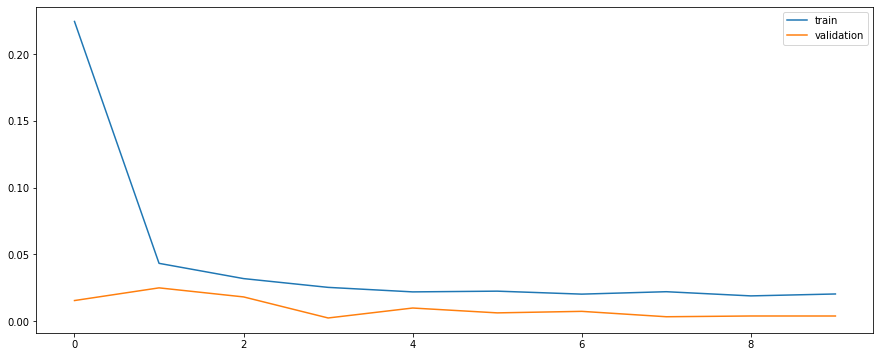

In [11]:
plt.figure(figsize=(15,6))
plt.plot(history15.history["loss"], label="train")
plt.plot(history15.history["val_loss"], label="validation")
plt.legend()

In [12]:
y15_pred = lstm15.predict(X15_test)
y15_train_inv = y15scale.inverse_transform(y15_train.reshape(1, -1))
y15_test_inv = y15scale.inverse_transform(y15_test.reshape(1, -1))
y15_pred_inv = y15scale.inverse_transform(y15_pred)

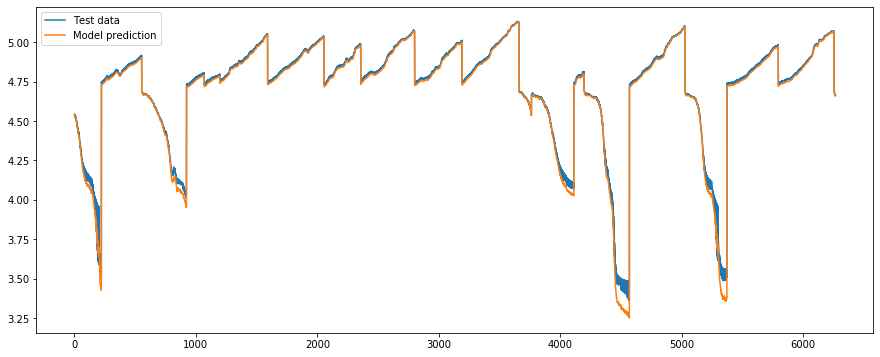

In [13]:
plt.figure(figsize=(15,6))
plt.plot(y15_test_inv.flatten(), label="Test data")
plt.plot(y15_pred_inv.flatten(), label="Model prediction")
plt.legend()